In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import math

from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error

data = pd.read_csv( "Electrical Grid.csv" )

data_x = data.drop(['stab','stabf'],axis=1)
data_y = data['stab']

scaler = MinMaxScaler()
scaled_x = scaler.fit_transform(data_x)
scaled_x = pd.DataFrame(scaled_x, columns=data_x.columns)

def get_random_subset(iterable,k):
    subsets = []
    iteration = 0
    np.random.shuffle(iterable)
    subset = 0
    limit = len(iterable)/k
    while iteration < limit:
        if k <= len(iterable):
            subset = k
        else:
            subset = len(iterable)
        subsets.append(iterable[-subset:])
        del iterable[-subset:]
        iteration+=1
    return subsets
def get_random_subset(iterable,k):
    subsets = []
    iteration = 0
    np.random.shuffle(iterable)
    subset = 0
    limit = len(iterable)/k
    while iteration < limit:
        if k <= len(iterable):
            subset = k
        else:
            subset = len(iterable)
        subsets.append(iterable[-subset:])
        del iterable[-subset:]
        iteration+=1
    return subsets

def weighted_average(prediction_set,oobrmse):
    final_results = []
    for i in range(len(prediction_set[0])): #總共要預測的Y有幾個 #2000個預測值
        predict_result = [] #存放每棵樹的預測值 #100棵樹有100個預測值
        final_result = 0
        for j in range(len(prediction_set)): #每棵樹的預測值 #100棵樹
            predict_result.append( (prediction_set[j][i]) )

        for k in range(len(predict_result)): #加權預測值
            final_result =  final_result + predict_result[k] * oobrmse[k]
        final_results.append(final_result)
    return final_results

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def Tree_Weighting_Rotation_Forest(X , Y, test_x, max_depth, size, n_trees, k):
    strength_set = []
    Prediction_set = []
    OOB_MSE = []
    r_matrices , models = [],[]
    for tree in range(n_trees):
        feature_index = list(range(X.shape[1]))
        k_subset = get_random_subset(feature_index,k) #每個子集有k個特徵，每個子集特徵不重複 #將訓練集中的屬性拆分為大小相等的 K 個非重疊子集。
        rotation_matrix = np.zeros((X.shape[1],X.shape[1]),dtype=float) #591*591大小的矩陣
        X_train, X_valid, y_train, y_valid = train_test_split(X, Y, train_size = size)

        for each_subset in k_subset:
            pca = PCA()
            x_train,_,_,_ = train_test_split(X_train, y_train, train_size = 0.7)
            X_subset = x_train.iloc[:,each_subset]
            pca.fit(X_subset)
            for i in range(0,len(pca.components_)):
                for j in range(0,len(pca.components_)):
                    rotation_matrix[ each_subset[i],each_subset[j] ] = pca.components_[i,j]

        x_transformed = X_train.dot(rotation_matrix)
        model = DecisionTreeRegressor(max_depth = max_depth).fit(x_transformed,y_train)

        x_valid_transformed = X_valid.dot(rotation_matrix)
        valid_prediction = model.predict(x_valid_transformed)

        models.append(model) #存放每個樹的模型
        r_matrices.append(rotation_matrix) #存放每個樹的旋轉矩陣

        OOB_MSE.append(mean_squared_error(y_valid,valid_prediction) )

    oob_mse_prop = OOB_MSE/np.sum(OOB_MSE)

    predicted_ys = [] #測試階段預測
    for i,model in enumerate(models):
        x_mod =  test_x.dot(r_matrices[i])
        predicted_y = model.predict(x_mod)
        predicted_ys.append(predicted_y)

    weighted_result = weighted_average(predicted_ys,oob_mse_prop)
    return weighted_result

def plot(rmse_set , parameter_set ,x_label ,title,labels):
    plt.figure(figsize=(4,3),dpi=100,linewidth = 2)
    plt.plot(parameter_set,rmse_set,'o-',color = 'deepskyblue', label=labels)
    plt.title(title, x=0.5, y=1.03)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel(x_label, fontsize=10 , labelpad = 5)
    plt.ylabel("RMSE", fontsize=10, labelpad = 5)
    plt.legend(loc = "best", fontsize=10)
    plt.show()

10
20
30
40
50
[0.013441666020795126, 0.012459643359788967, 0.012447295040504971, 0.012433907371673044, 0.0124174327510463]


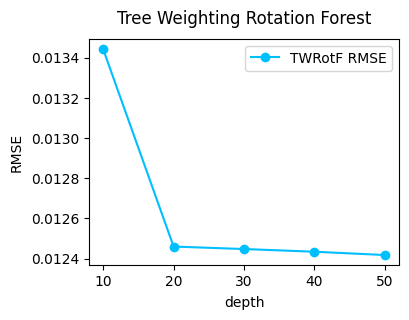

In [ ]:
kf = KFold(n_splits=5,random_state=42,shuffle=True)

RMSE_set_rf_depth ,mape_set_rf_depth = [],[]
import matplotlib.pyplot as plt
cnt = 1
depths = [10,20,30,40,50]
for depth in depths:
    print(depth)
    RMSE_set_rf ,mape_set_rf= [],[]
    for train_index, valid_index in kf.split(scaled_x, data_y): # split()  method generate indices to split data intSo training and test set.
        #print('fold',cnt)
        train_x = scaled_x.iloc[train_index,:]
        train_y = data.iloc[train_index,:]['stab']
        valid_x = scaled_x.iloc[valid_index,:]
        valid_y = data.iloc[valid_index,:]['stab']

        SRF = Tree_Weighting_Rotation_Forest( train_x,train_y,valid_x,max_depth=depth,size=0.7,n_trees=300, k = 3 )
        RMSE_set_rf.append( np.sqrt( mean_squared_error(valid_y,SRF)))

    RMSE_set_rf_depth.append(np.mean(RMSE_set_rf))

print(RMSE_set_rf_depth)
plot(rmse_set = RMSE_set_rf_depth , parameter_set = depths ,x_label = "depth" ,title= "Tree Weighting Rotation Forest", labels= "TWRotF RMSE")

0.5
0.7
0.9
[0.013342462180635936, 0.01277352570318183, 0.012449982142792847]


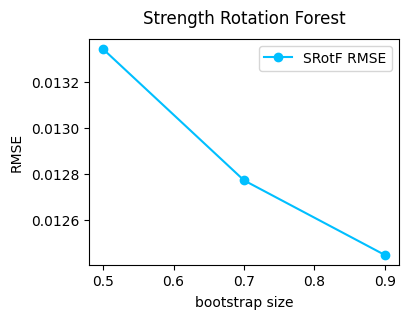

In [ ]:
kf = KFold(n_splits=5,random_state=42,shuffle=True)

RMSE_set_rf_depth ,mape_set_rf_depth = [],[]
import matplotlib.pyplot as plt
cnt = 1
bootstrap_sizes = [0.5,0.7,0.9]

for bootstrap_size in bootstrap_sizes:
    print(bootstrap_size)
    RMSE_set_rf ,mape_set_rf= [],[]
    for train_index, valid_index in kf.split(scaled_x, data_y): # split()  method generate indices to split data intSo training and test set.
        #print('fold',cnt)
        train_x = scaled_x.iloc[train_index,:]
        train_y = data.iloc[train_index,:]['stab']
        valid_x = scaled_x.iloc[valid_index,:]
        valid_y = data.iloc[valid_index,:]['stab']

        SRF = Tree_Weighting_Rotation_Forest(train_x , train_y, valid_x, max_depth = 30 , size = bootstrap_size , n_trees = 300, k = 3)
        RMSE_set_rf.append( np.sqrt( mean_squared_error(valid_y,SRF)))

    RMSE_set_rf_depth.append(np.mean(RMSE_set_rf))

print(RMSE_set_rf_depth)
plot(rmse_set = RMSE_set_rf_depth , parameter_set = bootstrap_sizes ,x_label = "bootstrap size" ,title= "Tree Weighting Rotation Forest", labels= "TWrotF RMSE")

300
500
700
900
[0.012117620478099713, 0.012060298846715273, 0.012085952977117547, 0.012075287986089105]


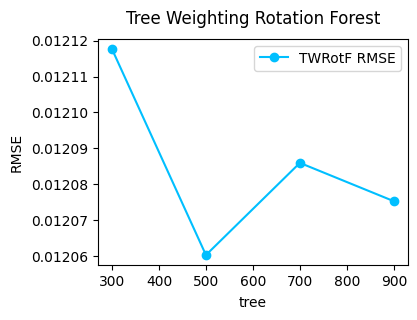

In [ ]:
kf = KFold(n_splits=5,random_state=42,shuffle=True)

RMSE_set_rf_depth ,mape_set_rf_depth = [],[]
import matplotlib.pyplot as plt
cnt = 1

trees = [300,500,700,900]

for tree in trees:
    print(tree)
    RMSE_set_rf ,mape_set_rf= [],[]
    for train_index, valid_index in kf.split(scaled_x, data_y): # split()  method generate indices to split data intSo training and test set.
        #print('fold',cnt)
        train_x = scaled_x.iloc[train_index,:]
        train_y = data.iloc[train_index,:]['stab']
        valid_x = scaled_x.iloc[valid_index,:]
        valid_y = data.iloc[valid_index,:]['stab']

        SRF = Tree_Weighting_Rotation_Forest(train_x , train_y, valid_x, max_depth = 30 , size = 0.9 , n_trees = tree, k = 3)
        RMSE_set_rf.append( np.sqrt( mean_squared_error(valid_y,SRF)))

    RMSE_set_rf_depth.append(np.mean(RMSE_set_rf))

print(RMSE_set_rf_depth)
plot(rmse_set = RMSE_set_rf_depth , parameter_set = trees ,x_label = "tree" ,title= "Tree Weighting Rotation Forest", labels= "TWRotF RMSE")

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
cnt = 1
RMSE_set_rotf = []

for train_index, valid_index in kf.split(scaled_x, data_y): # split()  method generate indices to split data intSo training and test set.
    print('fold',cnt)
    train_x = scaled_x.iloc[train_index,:]
    train_y = data.iloc[train_index,:]['stab']
    valid_x = scaled_x.iloc[valid_index,:]
    valid_y = data.iloc[valid_index,:]['stab']

    SRF = Tree_Weighting_Rotation_Forest(train_x , train_y, valid_x, max_depth = 30, size = 0.9, n_trees = 500, k = 3)
    RMSE_set_rotf.append( np.sqrt( mean_squared_error(valid_y,SRF)))

    cnt+=1

print("srof",RMSE_set_rotf)
print("mean",np.mean(RMSE_set_rotf) )

fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
srof [0.012285161660667525, 0.012080056415805658, 0.012130571901961665, 0.011699112955400638, 0.01165233214825341, 0.011553822157087463, 0.011187389194718433, 0.012005395494882677, 0.01184448495692941, 0.012644391108139003]
mean 0.011908271799384588
